In [2]:
%load_ext autoreload
%autoreload 1
%autosave 60

Autosaving every 60 seconds


In [3]:
import sys
import pandas as pd
import numpy as np
import importlib
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import seaborn as sb
from scipy import stats
from sklearn.decomposition import PCA
import scanpy
from anndata import AnnData
import umap
import anndata
from matplotlib.colors import LogNorm
from difflib import SequenceMatcher
from adjustText import adjust_text
import itertools
from sklearn.mixture import GaussianMixture
import matplotlib.scale as mscale
import matplotlib.transforms as mtransforms
import matplotlib.ticker as ticker
from matplotlib import colors
import ast
import matplotlib.cm as cm 
from scipy.stats import norm
import matplotlib.collections as mcoll

In [4]:
sys.path.append("/u/davidm/Documents/Master-thesis/Scripts/RNA-seq/python/")

In [5]:
import rnaseq
importlib.reload(rnaseq)

<module 'rnaseq' from '/u/davidm/Documents/Master-thesis/Scripts/RNA-seq/python/rnaseq/__init__.py'>

In [13]:
def hammingDist(str1, str2, fillchar = '-'):
    return sum([ch1 != ch2 for (ch1,ch2) in itertools.zip_longest(str1, str2, fillvalue = fillchar)])

In [14]:
def DFS(neighbors_mtx, component, barcode, visited):

    visited[barcode] = True
    component.append(barcode)
    
    neighbors = neighbors_mtx.index.values[neighbors_mtx[barcode] == 1]
    for neighbor in neighbors :
        if visited[neighbor][0] == False:
            component = DFS(neighbors_mtx, component, neighbor, visited)
    return component


def connectedComponents(neighbors_mtx) :
    
    barcodes = neighbors_mtx.index.values
    visited = pd.DataFrame([np.repeat(False, len(barcodes))], columns = barcodes, index = ["visited"])
    all_components = []

    for barcode in barcodes :
        if visited[barcode][0] == False:
            component = []
            all_components.append(DFS(neighbors_mtx, component, barcode, visited))
    
    i = np.argsort([len(c) for c in all_components])[::-1]
    
    return np.array(all_components, dtype = object)[i]

In [42]:
def plot_errors_1(correction_dict, barcodes, weight_by_lib = True) :
    nucleotides = ["A","T","G","C"]
    substitutions = {f"{pos}{nt1}": {nt2 : 0 for nt2 in nucleotides} for pos in np.arange(1,13) for nt1 in nucleotides}


    for barcode1 in correction_dict.keys() :
        for barcode2 in correction_dict[barcode1] :
            if barcode2 not in barcodes :
                continue
            pos = [i for i in range(len(barcode1)) if barcode1[i] != barcode2[i]][0]
            nt1 = list(barcode1)[pos]
            nt2 = list(barcode2)[pos]
            if weight_by_lib :
                substitutions[f"{pos+1}{nt1}"][nt2] += sc.obs["raw_cb_freq"].loc[barcode2]
            else :
                substitutions[f"{pos+1}{nt1}"][nt2] += 1
    
    counts = np.array([list(list(substitutions.values())[i].values()) for i in np.arange(48)])
    fig, ax = plt.subplots(figsize=(5.5,2.5))
    ax.set_prop_cycle('color', sb.color_palette("twilight_shifted", 4))
    bottom = 0
    for c in counts.T :
        ax.bar(np.arange(48), c, width = 0.7, bottom = bottom)
        bottom += c

    ax.legend(labels = nucleotides)
    plt.xticks(np.arange(48), labels = substitutions.keys(), rotation = 90)
    plt.ylim(0,np.max(bottom)+np.max(bottom)/30)
    plt.xlim(-1.5,48.5)
    plt.tight_layout()

In [32]:
def plot_errors(errors, libs, neighbors_mtx, weight_by_lib = True) :
    
    nucleotides = ["A","T","G","C"]
    substitutions = {f"{pos}{nt1}": {nt2 : 0 for nt2 in nucleotides} for pos in np.arange(1,13) for nt1 in nucleotides}
              
    for barcode2 in errors :
        
        neighbors = neighbors_mtx.index.values[neighbors_mtx[barcode2] == 1]
        sorting_df = pd.DataFrame(np.array([libs.loc[neighbors].values.ravel()]).T, columns = ["lib"], index = neighbors)
        sorted_comp = sorting_df.sort_values(by=["lib"], ascending=False).index.values
        barcode1 = sorted_comp[0]

        pos = [i for i in range(len(barcode1)) if barcode1[i] != barcode2[i]][0]
        nt1 = list(barcode1)[pos]
        nt2 = list(barcode2)[pos]
        if weight_by_lib :
            substitutions[f"{pos+1}{nt1}"][nt2] += libs.loc[barcode2]
        else :
            substitutions[f"{pos+1}{nt1}"][nt2] += 1
    
    counts = np.array([list(list(substitutions.values())[i].values()) for i in np.arange(48)])
    fig, ax = plt.subplots(figsize=(5.5,2.5))
    ax.set_prop_cycle('color', sb.color_palette("twilight_shifted", 4))
    bottom = 0
    for c in counts.T :
        ax.bar(np.arange(48), c, width = 0.7, bottom = bottom)
        bottom += c

    ax.legend(labels = nucleotides)
    plt.xticks(np.arange(48), labels = substitutions.keys(), rotation = 90)
    plt.ylim(0,np.max(bottom)+np.max(bottom)/30)
    plt.xlim(-1.5,48.5)
    plt.tight_layout()

In [16]:
def get_intended_barcodes(errors_dict, barcodes) :
    
    intended_list = []
    errors_list = []
    for intended, erroneous in errors_dict.items(): 
        for barcode in erroneous :
            if barcode in barcodes :
                errors_list.append(barcode)
                intended_list.append(intended)
    
    return np.array(intended_list), np.array(errors_list)

In [19]:
def get_whitelist(libs) :
    
    barcodes = libs.index
    whitelist = []
    errors = []
    correction_dict = {}

    neighbors_mtx = np.empty((len(barcodes), len(barcodes)))  
    for i in range(len(neighbors_mtx)) :
        barcode1 = sc.obs["CB"].values[i]
        neighbors_mtx[i] = [(hammingDist(barcode1, barcode2) == 1) for barcode2 in barcodes]
    neighbors_mtx = pd.DataFrame(neighbors_mtx, columns = barcodes, index = barcodes, dtype=int)
    
    all_components = connectedComponents(neighbors_mtx)
    
    for component in all_components :
                
        if len(component) == 1 :
            whitelist.append(component[0])
        else :
            sorting_df = pd.DataFrame(np.array([libs.loc[component].values.ravel()]).T, columns = ["lib"], index = component)
            sorted_comp = sorting_df.sort_values(by=["lib"], ascending=False).index.values
            barcode = sorted_comp[0]
            whitelist.append(barcode)
            errors.append(sorted_comp[1:])
            neighbors = neighbors_mtx.loc[barcode][sorted_comp]
            neighbors = neighbors.index.values[neighbors == 1]
            correction_dict[barcode] = neighbors

    
    return all_components, correction_dict, whitelist, np.concatenate(errors), neighbors_mtx

### Plotting parameters

In [11]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 110
plt.rcParams['font.size'] = 6

### Alevin 

In [141]:
sample = "Sample_N702_-_CTR1"
quant_params = "trimmed-reads-cutadapt/pc-decoys-k31-1.4.0/forceCells-3000-noWh"
genref = "human/assembly__GRCh38-hg38/annotation__gencode/gencode_34"
project = "dsp779"
prefix = f"pyplot_{sample}"

In [142]:
sc = rnaseq.readwrite.read_raw(project_id  = project, quant_tool = "alevin", samples = sample, genes_id = "ensembl_gene_id", quant_params = quant_params, genref = genref, cdna = "3' tag", exp = "sc")
sc._inplace_subset_obs(np.argsort(sc.obs["raw_cb_freq"].values)[::-1][:3000])

sc.obs_names = sc.obs["CB"]

rnaseq.setup.annotate_samples(sc, samples_annot_name = "total_UMIs", samples_annot = sc.X.toarray().sum(1).ravel(), ow=True)

Using BioMart Ensembl Genes 100 hsapiens_gene_ensembl for gene annotations.
Annotating total_UMIs...


In [143]:
sc.X.shape

(3000, 20305)

In [144]:
libs = sc.obs["raw_cb_freq"]

connected_components, correction_dict, whitelist, errors, neighbors_mtx = get_whitelist(libs)

# print(f"{len(whitelist)} barcodes in the new whitelist")

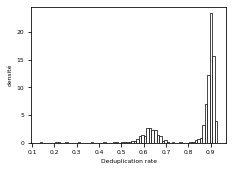

In [145]:
plt.subplots(figsize=(3.5,2.5))

plt.hist(sc.obs["DedupRate"].loc[errors], bins = 70, color = "white", edgecolor = 'black', linewidth = 0.7, density=True);
plt.xlabel("Deduplication rate");
plt.ylabel("densité");

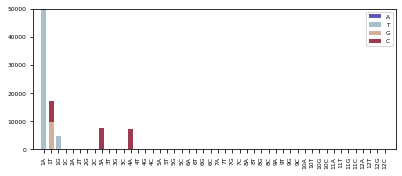

In [151]:
errors_seq = np.intersect1d(sc.obs.index[(sc.obs["DedupRate"]<0.7).values],errors)

plot_errors(errors_seq, libs, neighbors_mtx)
plt.ylim(0,50000);
# plt.savefig(f"./figs/{prefix}_all_errors.pdf")

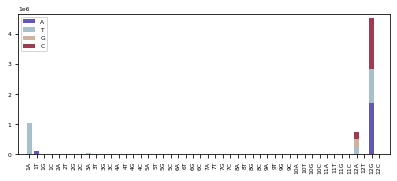

In [28]:
plot_errors(correction_dict, sc.obs_names);
plt.savefig(f"./figs/{prefix}_all_errors.pdf")

In [36]:
sample = "Sample_MCF7-labbo"
sample = "Sample_MCF7-atcc"

quant_params = "trimmed-reads-cutadapt/pc-decoys-k31-1.4.0/forceCells-3000-noWh"
genref = "human/assembly__GRCh38-hg38/annotation__gencode/gencode_34"
project = "dsp762"
prefix = f"pyplot_{sample}"

In [37]:
sc = rnaseq.readwrite.read_raw(project_id  = project, quant_tool = "alevin", samples = sample, genes_id = "ensembl_gene_id", quant_params = quant_params, genref = genref, cdna = "3' tag", exp = "sc")
sc._inplace_subset_obs(np.argsort(sc.obs["raw_cb_freq"].values)[::-1][:3000])

sc.obs_names = sc.obs["CB"]

rnaseq.setup.annotate_samples(sc, samples_annot_name = "total_UMIs", samples_annot = sc.X.toarray().sum(1).ravel(), ow=True)

Using BioMart Ensembl Genes 100 hsapiens_gene_ensembl for gene annotations.
Annotating total_UMIs...


In [38]:
sc.X.shape

(3000, 20305)

In [40]:
libs = sc.obs["raw_cb_freq"]

connected_components, correction_dict, whitelist, errors, neighbors_mtx = get_whitelist(libs)

print(f"{len(whitelist)} barcodes in the new whitelist")

2215 barcodes in the new whitelist


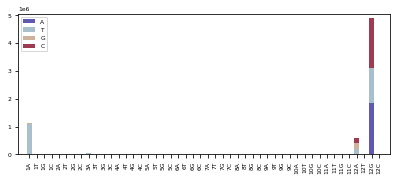

In [44]:
plot_errors(errors, libs, neighbors_mtx);
# plt.title(f"{sample} ({project})")
# plt.savefig(f"./figs/{prefix}_all_errors.pdf")

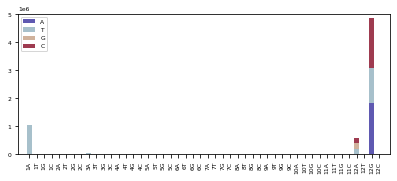

In [43]:
plot_errors_1(correction_dict, sc.obs_names);
# plt.title(f"{sample} ({project})")
# plt.savefig(f"./figs/{prefix}_all_errors.pdf")

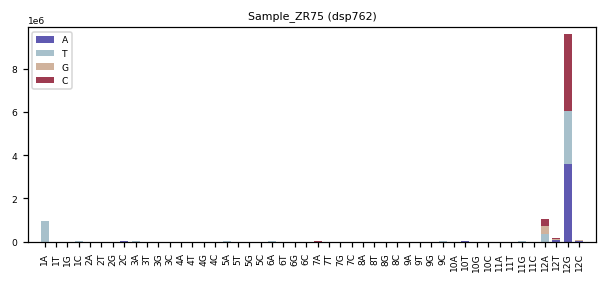

In [105]:
plot_errors(correction_dict, sc.obs_names);
plt.title(f"{sample} ({project})")
plt.savefig(f"./figs/{prefix}_all_errors.pdf")

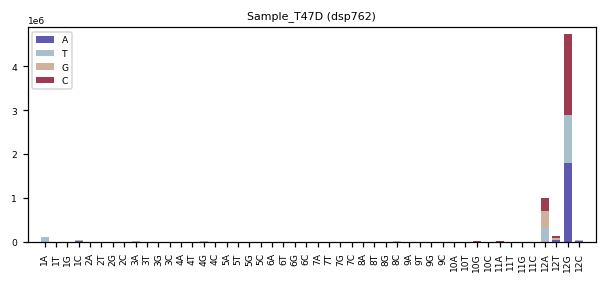

In [110]:
plot_errors(correction_dict, sc.obs_names);
plt.title(f"{sample} ({project})")
plt.savefig(f"./figs/{prefix}_all_errors.pdf")

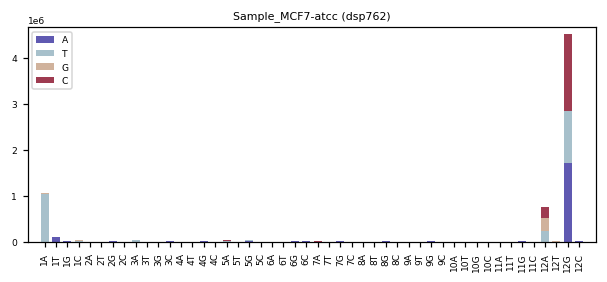

In [115]:
plot_errors(correction_dict, sc.obs_names);
plt.title(f"{sample} ({project})")
plt.savefig(f"./figs/{prefix}_all_errors.pdf")

In [52]:
len(errors)

534

In [109]:
sample = "Sample_SKBR3_N712"
# sample = "Sample_HCC70_N703"
# sample = "Sample_BT20_N701"
# sample = "Sample_EV_N707_NEWsample"

quant_params = "trimmed-reads-cutadapt/pc-decoys-k31-1.4.0/forceCells-3000-noWh"
# quant_params = "trimmed-reads-cutadapt/pc-EGFP-decoys-k31-1.4.0/forceCells-3000-noWh"

genref = "human/assembly__GRCh38-hg38/annotation__gencode/gencode_34"
project = "dsp992"
# project = "dsp1090"
prefix = f"pyplot_{sample}"

In [110]:
sc = rnaseq.readwrite.read_raw(project_id  = project, quant_tool = "alevin", samples = sample, genes_id = "ensembl_gene_id", quant_params = quant_params, genref = genref, cdna = "3' tag", exp = "sc")
sc._inplace_subset_obs(np.argsort(sc.obs["raw_cb_freq"].values)[::-1][:3000])

sc.obs_names = sc.obs["CB"]

rnaseq.setup.annotate_samples(sc, samples_annot_name = "total_UMIs", samples_annot = sc.X.toarray().sum(1).ravel(), ow=True)

Using BioMart Ensembl Genes 100 hsapiens_gene_ensembl for gene annotations.
Annotating total_UMIs...


In [111]:
sc.X.shape

(3000, 20305)

In [112]:
libs = sc.obs["raw_cb_freq"]

connected_components, correction_dict, whitelist, errors, neighbors_mtx = get_whitelist(libs)

print(f"{len(whitelist)} barcodes in the new whitelist")

2665 barcodes in the new whitelist


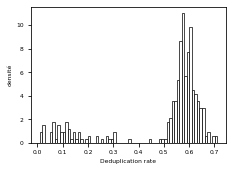

In [113]:
plt.subplots(figsize=(3.5,2.5))

plt.hist(sc.obs["DedupRate"].loc[errors], bins = 70, color = "white", edgecolor = 'black', linewidth = 0.7, density=True);
plt.xlabel("Deduplication rate");
plt.ylabel("densité");

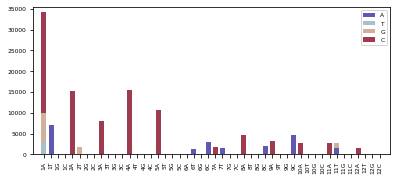

In [114]:
errors_seq = np.intersect1d(sc.obs.index[(sc.obs["DedupRate"]<0.3).values],errors)

plot_errors(errors_seq, libs, neighbors_mtx);
# plt.title(f"{sample} ({project})")
# plt.savefig(f"./figs/{prefix}_all_errors.pdf")

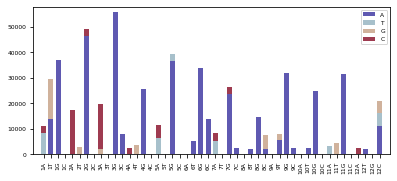

In [108]:
plot_errors(errors, libs, neighbors_mtx);
# plt.title(f"{sample} ({project})")
# plt.savefig(f"./figs/{prefix}_all_errors.pdf")

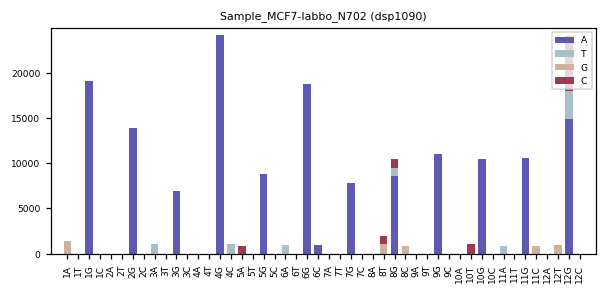

In [100]:
plot_errors_1(correction_dict, sc.obs_names);
# plt.title(f"{sample} ({project})")
# plt.savefig(f"./figs/{prefix}_all_errors.pdf")

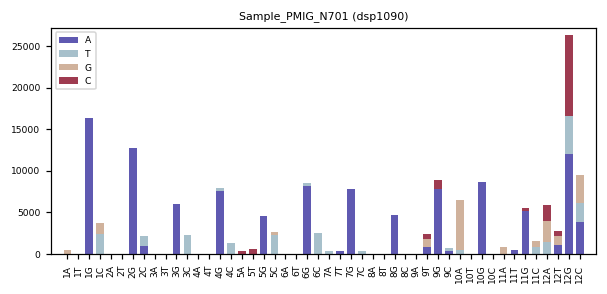

In [120]:
plot_errors(correction_dict, sc.obs_names);
plt.title(f"{sample} ({project})")
plt.savefig(f"./figs/{prefix}_all_errors.pdf")

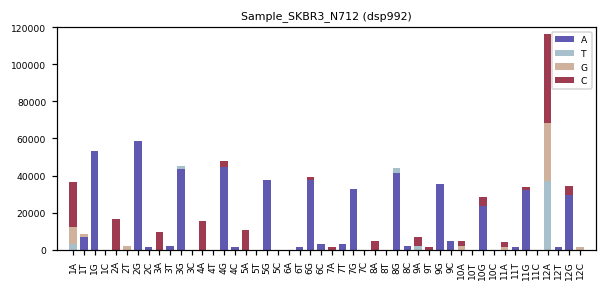

In [124]:
plot_errors(correction_dict, sc.obs_names);
plt.title(f"{sample} ({project})")
plt.savefig(f"./figs/{prefix}_all_errors.pdf")

In [95]:
len(errors)

191